# New MNIST Code

Same dense neural network, but written with object-oriented syntax.

In [1]:
import numpy as np
import os

class NeuralNetwork:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    @staticmethod
    def sigmoid_(x):
        return NeuralNetwork.sigmoid(x) * (1 - NeuralNetwork.sigmoid(x))
    @staticmethod
    def mae(answer, expected):
        return np.sum((answer - expected) ** 2)
    @staticmethod
    def mae_(answer, expected):
        return 2 * (answer - expected)
    @staticmethod
    def l1(answer, expected):
        return np.sum(np.abs(answer - expected))
    @staticmethod
    def l1_(answer, expected):
        return np.sign(answer - expected)
    @staticmethod
    def crossEntropy(answer, expected):
        return -np.sum(expected * np.log(answer)) - np.sum((1 - expected) * np.log(1 - answer))
    @staticmethod
    def crossEntropy_(answer, expected):
        return -expected / answer + (1 - expected) / (1 - answer)

    def __init__(self, *args, **kwargs):
        self.weight = [np.random.randn(args[i+1], args[i]) for i in range(len(args) - 1)]
        self.bias = [np.random.randn(args[i+1]) for i in range(len(args) - 1)]
        self.activation, self.activation_ = kwargs.get('activation', (NeuralNetwork.sigmoid, NeuralNetwork.sigmoid_))
        self.errorFunc, self.errorFunc_ = kwargs.get('errorFunc', (NeuralNetwork.mae, NeuralNetwork.mae_))
        self.learnRate = kwargs.get('learnRate', 0.01)
        self.gradient_clip_threshold = kwargs.get('gradient_clip_threshold', None)

    def predict(self, inputData):
        """
        Give the set of all the activation values on the network when given a set of input data.
        `inputData` is a 2D numpy array, with its first index being the index of patches
        and the second index being the index of input neuron in one patch.
        Or: `inputData[k, i]` is the value of the i-th input neuron in the k-th patch.
        """
        if len(inputData.shape) == 1:
            inputData = inputData.reshape(1, inputData.shape[0])
        ans = [(None, inputData)]
        for i in range(len(self.bias)):
            before = np.matmul(ans[-1][1], self.weight[i].T) + self.bias[i]
            ans.append((before, self.activation(before)))
        return ans
    def apply(self, inputData):
        return self.predict(inputData)[-1][1]

    def backPropagate(self, predicted, outputErr):
        """
        Get the partial derivatives of the error function over the input values of each layer.
        `predicted` is the return value of `predict`.
        `outputErr` is the partial derivatives of the error function over the output values of the last layer.
        `outputErr[k, i]` is the partial derivative of the error function over the output value of the i-th neuron in the k-th patch.
        """
        ans = [outputErr]
        for i in reversed(range(len(self.bias))):
            gradient = np.matmul(ans[0] * self.activation_(predicted[i+1][0]), self.weight[i])
            if np.average(gradient * gradient) > self.gradient_clip_threshold * self.gradient_clip_threshold:
                gradient = gradient / np.sqrt(np.average(gradient * gradient)) * self.gradient_clip_threshold
            ans.insert(0, gradient)
        return ans

    def update(self, predicted, partials):
        batch_size = predicted[0][1].shape[0]
        bias_ = [partials[i+1] * self.activation_(predicted[i+1][0]) for i in range(len(self.bias))]
        weight_ = [np.matmul(np.transpose(bias_[i]), predicted[i][1]) / batch_size for i in range(len(self.weight))]
        for i in range(len(self.bias)):
            bias_[i] = np.mean(bias_[i], axis=0)
            self.bias[i] -= self.learnRate * bias_[i]
            self.weight[i] -= self.learnRate * weight_[i]

    def save_model(self, path, name):
        for i, weight in enumerate(self.weight):
            np.save(os.path.join(path, name + '_weight_' + str(i) + '.npy'), weight)
        for i, bias in enumerate(self.bias):
            np.save(os.path.join(path, name + '_bias_' + str(i) + '.npy'), bias)
    
    def load_model(self, path, name, num_layers):
        self.weight = [np.load(os.path.join(path, name + '_weight_' + str(i) + '.npy')) for i in range(num_layers)]
        self.bias = [np.load(os.path.join(path, name + '_bias_' + str(i) + '.npy')) for i in range(num_layers)]

In [2]:
import csv
import numpy as np

with open("train.csv") as trainFile:
    train = list(csv.reader(trainFile))
    label = np.array([train[i][0] for i in range(1, len(train))], dtype=np.int32)
    image = np.array([np.array(train[i][1:], dtype=float) / 255 for i in range(1, len(train))])

print(len(image[0]))

784


1


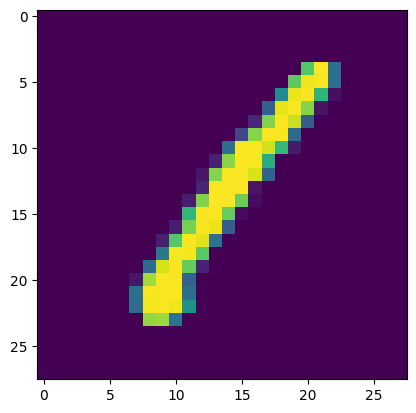

In [3]:
import matplotlib.pyplot as plt
plt.imshow(image[0].reshape(28, 28))
print(label[0])

In [4]:
model = NeuralNetwork(784, 16, 16, 10, activation=(NeuralNetwork.sigmoid, NeuralNetwork.sigmoid_), errorFunc=(NeuralNetwork.crossEntropy, NeuralNetwork.crossEntropy_))

In [5]:
# training 1 step
inputData = image[0].reshape(1, 784)
expected = np.zeros(10)
expected[int(label[0])] = 1
predicted = model.predict(inputData)
print("--- before training ---")
print(predicted[-1][1])
print(model.errorFunc(predicted[-1][1], expected))
partials = model.backPropagate(predicted, model.errorFunc_(predicted[-1][1], expected))
model.update(predicted, partials)
predicted = model.predict(inputData)
print("--- after training ---")
print(predicted[-1][1])
print(model.errorFunc(predicted[-1][1], expected))

--- before training ---
[[0.7699123  0.31191473 0.53153798 0.99728511 0.20944066 0.95577565
  0.27314494 0.5014884  0.03800539 0.89587447]]
15.971178441337859
--- after training ---
[[0.75384879 0.34231231 0.48126334 0.99677399 0.24333042 0.94776307
  0.30160302 0.48118043 0.03753589 0.87819572]]
15.256269750832995


In [6]:
from tqdm import tqdm

batch_size = 8
training_accuracies = []
DATA_PER_RECORD = 50000

for i in tqdm(range(1000000)):
    # select 8 random indices from the train set and use them as the input data
    indices = np.random.choice(len(image), batch_size, replace=False).astype(np.int32)
    inputData = image[indices]
    expected = np.zeros((batch_size, 10))
    expected[np.arange(batch_size), label[indices[np.arange(batch_size)]].astype(np.int32)] = 1
    # train the model
    predicted = model.predict(inputData)
    error = model.errorFunc(predicted[-1][1], expected)
    if i % DATA_PER_RECORD == 0:
        # calculate training accuracy
        correct = 0
        for j in range(len(image)):
            if np.argmax(model.apply(image[j])) == int(label[j]):
                correct += 1
        training_accuracies.append(correct / len(image))
    partials = model.backPropagate(predicted, model.errorFunc_(predicted[-1][1], expected))
    model.update(predicted, partials)

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [18:02<00:00, 923.80it/s] 


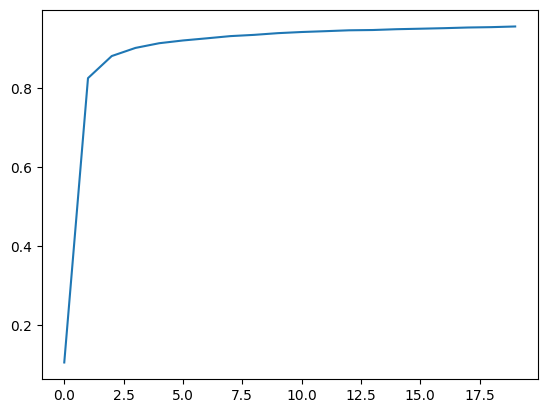

[0.10478571428571429, 0.8257142857142857, 0.8817142857142857, 0.9023333333333333, 0.9142380952380952, 0.9212142857142858, 0.9266428571428571, 0.9322619047619047, 0.9354285714285714, 0.9397619047619048, 0.9426428571428571, 0.9447619047619048, 0.947, 0.9477142857142857, 0.9497619047619048, 0.9510238095238095, 0.9523809523809523, 0.9540714285714286, 0.955, 0.9566904761904762]


In [12]:
# plot training accuracy data
plt.plot(training_accuracies)
plt.show()
print(training_accuracies)

In [8]:
with open("test.csv") as testFile:
    test = list(csv.reader(testFile))
    testImage = [np.array(test[i], dtype=float) / 255 for i in range(1, len(test))]

array([[5.78267166e-04, 2.31839329e-03, 9.94934276e-01, 9.82691365e-03,
        1.07153729e-05, 2.09335394e-06, 2.08760325e-04, 1.81883725e-03,
        7.50328003e-03, 1.05471282e-05]])

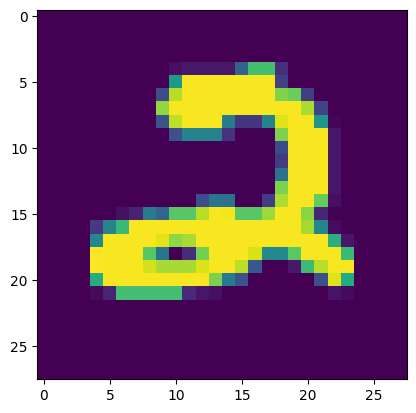

In [9]:
plt.imshow(testImage[0].reshape(28, 28))
model.predict(testImage[0])[3][1]

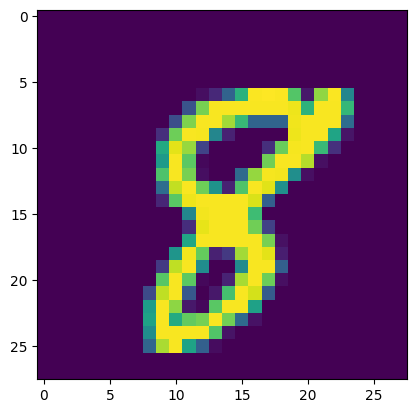

label: 8
total= 0 ; correct= 0


In [11]:
toNext = True
total = 0
correct = 0

while toNext:
    index = np.random.randint(len(testImage))
    plt.imshow(testImage[index].reshape(28, 28))
    plt.show()
    print("label:", np.argmax(model.apply(testImage[index])))
    result = input()
    if result == "q" or result == "Q" or result == "f" or result == "F":
        toNext = False
    elif result == "r" or result == "c" or result == "R" or result == "C" or result == "t" or result == "T":
        correct += 1
        total += 1
    else:
        total += 1
    
print("total=", total, "; correct=", correct)